In [1]:
import optuna
import os
import random
import easydict
import torch
import numpy as np
import pandas as pd

from tqdm import tqdm
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
def generate_data_loader(file_path, tokenizer, args):

    def get_input_ids(data):
        document_bert = ["[CLS] " + str(s) + " [SEP]" for s in data]
        tokenized_texts = [tokenizer.tokenize(s) for s in tqdm(document_bert, "Tokenizing")]
        input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenized_texts, "Converting tokens to ids")]
        print("Padding sequences...")
        input_ids = pad_sequences(input_ids, maxlen=args.maxlen, dtype='long', truncating='post', padding='post')
        return input_ids

    def get_attention_masks(input_ids):
        attention_masks = []
        for seq in tqdm(input_ids, "Generating attention masks"):
            seq_mask = [float(i > 0) for i in seq]
            attention_masks.append(seq_mask)
        return attention_masks

    def get_data_loader(inputs, masks, labels, batch_size=args.batch):
        data = TensorDataset(torch.tensor(inputs), torch.tensor(masks), torch.tensor(labels))
        sampler = RandomSampler(data) if args.mode == 'train' else SequentialSampler(data)
        data_loader = DataLoader(data, sampler=sampler, batch_size=batch_size)
        return data_loader

    data_df = pd.read_csv(file_path)
    input_ids = get_input_ids(data_df['text'].values)
    attention_masks = get_attention_masks(input_ids)
    data_loader = get_data_loader(input_ids, attention_masks, data_df['label'].values if args.mode=='train' else [-1]*len(data_df))

    return data_loader

In [3]:
def save(model, dir_name):
    os.makedirs(dir_name, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(dir_name, 'model.pth'))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [4]:
def predict(model, args, data_loader):
    print('start predict')
    model.eval()

    eval_loss = []
    eval_accuracy = []
    logits = []

    for step, batch in tqdm(enumerate(data_loader)):
        batch = tuple(t.to(args.device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            if args.mode == 'test':
                outputs = model(b_input_ids, attention_mask=b_input_mask)
                logit = outputs[0]
            else:
                outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
                loss, logit = outputs[:2]
                eval_loss.append(loss.item())

        logit = logit.detach().cpu().numpy()
        label = b_labels.cpu().numpy()

        logits.append(logit)

        if args.mode != 'test':
            accuracy = flat_accuracy(logit, label)
            eval_accuracy.append(accuracy)

    logits = np.vstack(logits)
    predict_labels = np.argmax(logits, axis=1)

    if args.mode == 'test':
        return predict_labels, None

    avg_eval_loss = np.mean(eval_loss)
    avg_eval_accuracy = np.mean(eval_accuracy)

    return predict_labels, avg_eval_loss, avg_eval_accuracy

In [11]:
def train(model, args, train_loader, valid_loader, patience=5):
    accumulation_steps = 4  # Gradient를 누적할 배치의 수
    experiment_name = f"v_8_model_ckpt_{args.model_ckpt.replace('/', '_')}_lr_{args.lr}_batch_{args.batch}_epochs_{args.epochs}_maxlen_{args.maxlen}_eps_{args.eps}"
    writer = SummaryWriter(f'hai_kaggle/{experiment_name}')

    optimizer = AdamW(model.parameters(),
                      lr=args.lr,
                      eps=args.eps
                      )
    total_steps = len(train_loader) * args.epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)

    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    best_val_accuracy = 0.0
    best_train_accuracy = 0.0
    epochs_without_improvement = 0

    train_accuracies = []
    val_accuracies = []

    print('start training')
    for epoch in range(args.epochs):
        model.train()
        train_loss = []
        
        optimizer.zero_grad()  # Gradient 초기화
        
        for step, batch in tqdm(enumerate(train_loader), f"training epoch {epoch}", total=len(train_loader)):
            batch = tuple(t.to(args.device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)
            loss = outputs[0] / accumulation_steps  # Gradient Accumulation을 위해 loss를 나눈다.
            train_loss.append(loss.item())
            loss.backward()

            # accumulation_steps마다 optimizer 업데이트
            if (step + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()  
                optimizer.zero_grad()

            writer.add_scalar('training loss',
                            loss.item(),
                            epoch * len(train_loader) + step)

        avg_train_loss = np.mean(train_loss)
        _, _, avg_train_accuracy = predict(model, args, train_loader)
        _, _, avg_val_accuracy = predict(model, args, valid_loader)
        print("Epoch {0},  Average training loss: {1:.4f} , Train accuracy : {2:.4f}, Validation accuracy : {3:.4f}"
              .format(epoch, avg_train_loss, avg_train_accuracy, avg_val_accuracy))

        train_accuracies.append(avg_train_accuracy)
        val_accuracies.append(avg_val_accuracy)

        writer.add_scalar('training accuracy',
                        avg_train_accuracy,
                        epoch)
        writer.add_scalar('validation accuracy',
                        avg_val_accuracy,
                        epoch)

        if avg_val_accuracy > best_val_accuracy:
            best_val_accuracy = avg_val_accuracy
            best_train_accuracy = avg_train_accuracy
            epochs_without_improvement = 0
            save_path = f"./saved_checkpoints/best_model/{experiment_name}_TrainAcc_{best_train_accuracy}_ValAcc_{best_val_accuracy}"
            save(model, save_path)
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"[Early Stopping]{patience} epoch에서 중단.[Early Stopping]")
            break
            
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epoch + 2), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epoch + 2), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    model_path = f"./saved_checkpoints/best_model/{experiment_name}_TrainAcc_{best_train_accuracy}_ValAcc_{best_val_accuracy}/model.pth"
    model.load_state_dict(torch.load(model_path))

    print(f"Best Train Accuracy: {best_train_accuracy}, Best Validation Accuracy: {best_val_accuracy}")

    writer.add_hparams({
        'lr': args.lr,
        'eps': args.eps,
        'batch': args.batch,
        'epochs': args.epochs,
        'maxlen': args.maxlen
        }, {
        'best_train_accuracy': best_train_accuracy,
        'best_val_accuracy': best_val_accuracy
        })

    writer.close()
    return model, best_train_accuracy, best_val_accuracy, train_accuracies, val_accuracies

In [12]:
def train_valid(args):
    if torch.cuda.is_available():
        args.device = 'cuda'
    else:
        args.device = 'cpu'

    model = AutoModelForSequenceClassification.from_pretrained(args.model_ckpt, num_labels=3)
    model.to(args.device)
    tokenizer = AutoTokenizer.from_pretrained(args.model_ckpt)

    train_dataloader = generate_data_loader(args.train_path, tokenizer, args)
    validation_dataloader = generate_data_loader(args.valid_path, tokenizer, args)

    model, best_train_accuracy, best_val_accuracy, train_accuracies, val_accuracies = train(model, args, train_dataloader, validation_dataloader)

    return model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy

In [13]:
# best_train_accuracy & best_val_accuracy는 모델 경로 때문에 주는 것임!
def test(model, tokenizer, test_args, file_path, args, best_train_accuracy, best_val_accuracy):
    if torch.cuda.is_available():
        test_args.device = 'cuda'

    test_dataloader = generate_data_loader(file_path, tokenizer=tokenizer, args=test_args)
    labels, _ = predict(model, test_args, test_dataloader)

    submit_df = pd.DataFrame()
    submit_df["idx"] = range(len(labels))
    submit_df["label"] = labels
    save_path = f"./saved_checkpoints/best_model/v_8_model_ckpt_{args.model_ckpt.replace('/', '_')}_lr_{args.lr}_batch_{args.batch}_epochs_{args.epochs}_maxlen_{args.maxlen}_eps_{args.eps}_TrainAcc_{best_train_accuracy}_ValAcc_{best_val_accuracy}/submission.csv"
    submit_df.to_csv(save_path, index=False)
    print(f"Submission file saved to {save_path}")

In [14]:
def objective(trial):
    # 하이퍼파라미터 범위 설정
    lr = trial.suggest_loguniform('lr', 3e-7, 3e-5)
    batch = trial.suggest_int('batch', 64, 128, log=True)
    maxlen = trial.suggest_int('maxlen', 32, 128)
    eps = 1e-8

    optuna_args = easydict.EasyDict({
        "train_path": "./train.csv",
        "valid_path": "./valid.csv",
        "device" : 'cpu',
        "mode" : "train",
        "batch" : batch,
        "maxlen" : maxlen,
        "lr" : lr,
        "eps" : eps,
        "epochs" : 50,
        "model_ckpt" : "monologg/koelectra-small-v3-discriminator",
    })

    _, _, _, _, _, val_accuracy = train_valid(optuna_args)

    return val_accuracy  # 최적화 목표는 검증 정확도를 최대화하는 것입니다.

[I 2023-08-14 15:27:11,940] A new study created in memory with name: no-name-ec2da667-2482-4fb5-a263-daad243f7897
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 212143.66it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 257935.65it/s]


Padding sequences...


Generating attention masks: 100%|██████████| 973/973 [00:00<00:00, 61248.63it/s]


start training


training epoch 0: 100%|█████████████████████| 2244/2244 [03:13<00:00, 11.62it/s]


start predict


2244it [01:13, 30.40it/s]


start predict


12it [00:00, 32.48it/s]


Epoch 0,  Average training loss: 0.1559 , Train accuracy : 0.9040, Validation accuracy : 0.8951


training epoch 1: 100%|█████████████████████| 2244/2244 [03:14<00:00, 11.53it/s]


start predict


2244it [01:14, 30.23it/s]


start predict


12it [00:00, 32.43it/s]


Epoch 1,  Average training loss: 0.0728 , Train accuracy : 0.9245, Validation accuracy : 0.9106


training epoch 2: 100%|█████████████████████| 2244/2244 [03:15<00:00, 11.49it/s]


start predict


2244it [01:14, 30.22it/s]


start predict


12it [00:00, 32.44it/s]


Epoch 2,  Average training loss: 0.0599 , Train accuracy : 0.9327, Validation accuracy : 0.9174


training epoch 3: 100%|█████████████████████| 2244/2244 [03:15<00:00, 11.50it/s]


start predict


2244it [01:14, 30.22it/s]


start predict


12it [00:00, 32.37it/s]


Epoch 3,  Average training loss: 0.0540 , Train accuracy : 0.9379, Validation accuracy : 0.9148


training epoch 4: 100%|█████████████████████| 2244/2244 [03:15<00:00, 11.50it/s]


start predict


2244it [01:14, 30.22it/s]


start predict


12it [00:00, 32.61it/s]


Epoch 4,  Average training loss: 0.0501 , Train accuracy : 0.9443, Validation accuracy : 0.9204


training epoch 5: 100%|█████████████████████| 2244/2244 [03:14<00:00, 11.51it/s]


start predict


2244it [01:14, 30.25it/s]


start predict


12it [00:00, 32.59it/s]


Epoch 5,  Average training loss: 0.0468 , Train accuracy : 0.9473, Validation accuracy : 0.9211


training epoch 6: 100%|█████████████████████| 2244/2244 [03:14<00:00, 11.51it/s]


start predict


2244it [01:14, 30.24it/s]


start predict


12it [00:00, 32.78it/s]


Epoch 6,  Average training loss: 0.0443 , Train accuracy : 0.9513, Validation accuracy : 0.9216


training epoch 7: 100%|█████████████████████| 2244/2244 [03:14<00:00, 11.52it/s]


start predict


2244it [01:14, 30.26it/s]


start predict


12it [00:00, 32.52it/s]


Epoch 7,  Average training loss: 0.0417 , Train accuracy : 0.9541, Validation accuracy : 0.9255


training epoch 8: 100%|█████████████████████| 2244/2244 [03:14<00:00, 11.52it/s]


start predict


2244it [01:14, 30.27it/s]


start predict


12it [00:00, 32.53it/s]


Epoch 8,  Average training loss: 0.0399 , Train accuracy : 0.9565, Validation accuracy : 0.9231


training epoch 9: 100%|█████████████████████| 2244/2244 [03:14<00:00, 11.52it/s]


start predict


2244it [01:14, 30.29it/s]


start predict


12it [00:00, 32.50it/s]


Epoch 9,  Average training loss: 0.0382 , Train accuracy : 0.9599, Validation accuracy : 0.9233


training epoch 10: 100%|████████████████████| 2244/2244 [03:14<00:00, 11.53it/s]


start predict


2244it [01:14, 30.30it/s]


start predict


12it [00:00, 32.64it/s]


Epoch 10,  Average training loss: 0.0363 , Train accuracy : 0.9626, Validation accuracy : 0.9228


training epoch 11: 100%|████████████████████| 2244/2244 [03:14<00:00, 11.54it/s]


start predict


2244it [01:14, 30.30it/s]


start predict


12it [00:00, 32.76it/s]


Epoch 11,  Average training loss: 0.0348 , Train accuracy : 0.9640, Validation accuracy : 0.9275


training epoch 12: 100%|████████████████████| 2244/2244 [03:14<00:00, 11.54it/s]


start predict


2244it [01:14, 30.30it/s]


start predict


12it [00:00, 32.46it/s]


Epoch 12,  Average training loss: 0.0332 , Train accuracy : 0.9667, Validation accuracy : 0.9170


training epoch 13: 100%|████████████████████| 2244/2244 [03:14<00:00, 11.53it/s]


start predict


2244it [01:14, 30.27it/s]


start predict


12it [00:00, 32.49it/s]


Epoch 13,  Average training loss: 0.0320 , Train accuracy : 0.9690, Validation accuracy : 0.9236


training epoch 14: 100%|████████████████████| 2244/2244 [03:14<00:00, 11.53it/s]


start predict


2244it [01:14, 30.30it/s]


start predict


12it [00:00, 32.51it/s]


Epoch 14,  Average training loss: 0.0305 , Train accuracy : 0.9721, Validation accuracy : 0.9240


training epoch 15: 100%|████████████████████| 2244/2244 [03:14<00:00, 11.54it/s]


start predict


2244it [01:14, 30.30it/s]


start predict


12it [00:00, 32.55it/s]


Epoch 15,  Average training loss: 0.0293 , Train accuracy : 0.9717, Validation accuracy : 0.9275


training epoch 16: 100%|████████████████████| 2244/2244 [03:14<00:00, 11.53it/s]


start predict


2244it [01:14, 30.29it/s]


start predict


12it [00:00, 32.44it/s]


Epoch 16,  Average training loss: 0.0279 , Train accuracy : 0.9755, Validation accuracy : 0.9216
[Early Stopping]5 epoch에서 중단.[Early Stopping]


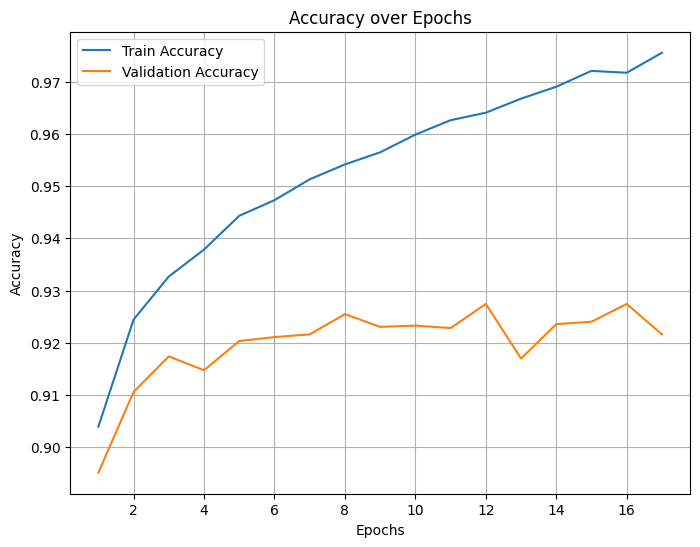

[I 2023-08-14 16:43:43,072] Trial 0 finished with value: 0.927450980392157 and parameters: {'lr': 1.9006694248745237e-05, 'batch': 85, 'maxlen': 92}. Best is trial 0 with value: 0.927450980392157.


Best Train Accuracy: 0.9640452972632905, Best Validation Accuracy: 0.927450980392157


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:01<00:00, 181638.06it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 256605.75it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 973/973 [00:00<00:00, 141792.02it/s]


start training


training epoch 0: 100%|█████████████████████| 1767/1767 [01:22<00:00, 21.40it/s]


start predict


1767it [00:29, 59.64it/s]


start predict


10it [00:00, 66.66it/s]


Epoch 0,  Average training loss: 0.2076 , Train accuracy : 0.7781, Validation accuracy : 0.7833


training epoch 1: 100%|█████████████████████| 1767/1767 [01:22<00:00, 21.44it/s]


start predict


1767it [00:29, 59.53it/s]


start predict


10it [00:00, 66.82it/s]


Epoch 1,  Average training loss: 0.1147 , Train accuracy : 0.9020, Validation accuracy : 0.9009


training epoch 2: 100%|█████████████████████| 1767/1767 [01:22<00:00, 21.41it/s]


start predict


1767it [00:29, 59.52it/s]


start predict


10it [00:00, 67.21it/s]


Epoch 2,  Average training loss: 0.0813 , Train accuracy : 0.9156, Validation accuracy : 0.9111


training epoch 3: 100%|█████████████████████| 1767/1767 [01:22<00:00, 21.42it/s]


start predict


1767it [00:29, 59.49it/s]


start predict


10it [00:00, 66.94it/s]


Epoch 3,  Average training loss: 0.0700 , Train accuracy : 0.9221, Validation accuracy : 0.9130


training epoch 4: 100%|█████████████████████| 1767/1767 [01:22<00:00, 21.42it/s]


start predict


1767it [00:29, 59.49it/s]


start predict


10it [00:00, 66.37it/s]


Epoch 4,  Average training loss: 0.0639 , Train accuracy : 0.9275, Validation accuracy : 0.8157


training epoch 5: 100%|█████████████████████| 1767/1767 [01:22<00:00, 21.41it/s]


start predict


1767it [00:29, 59.50it/s]


start predict


10it [00:00, 66.90it/s]


Epoch 5,  Average training loss: 0.0600 , Train accuracy : 0.9312, Validation accuracy : 0.9222


training epoch 6: 100%|█████████████████████| 1767/1767 [01:22<00:00, 21.41it/s]


start predict


1767it [00:29, 59.46it/s]


start predict


10it [00:00, 66.74it/s]


Epoch 6,  Average training loss: 0.0569 , Train accuracy : 0.9340, Validation accuracy : 0.9250


training epoch 7: 100%|█████████████████████| 1767/1767 [01:22<00:00, 21.42it/s]


start predict


1767it [00:29, 59.47it/s]


start predict


10it [00:00, 66.57it/s]


Epoch 7,  Average training loss: 0.0546 , Train accuracy : 0.9364, Validation accuracy : 0.9241


training epoch 8: 100%|█████████████████████| 1767/1767 [01:22<00:00, 21.42it/s]


start predict


1767it [00:29, 59.49it/s]


start predict


10it [00:00, 66.76it/s]


Epoch 8,  Average training loss: 0.0525 , Train accuracy : 0.9391, Validation accuracy : 0.9222


training epoch 9: 100%|█████████████████████| 1767/1767 [01:22<00:00, 21.40it/s]


start predict


1767it [00:29, 59.48it/s]


start predict


10it [00:00, 66.96it/s]


Epoch 9,  Average training loss: 0.0510 , Train accuracy : 0.9409, Validation accuracy : 0.9222


training epoch 10: 100%|████████████████████| 1767/1767 [01:22<00:00, 21.41it/s]


start predict


1767it [00:29, 59.44it/s]


start predict


10it [00:00, 66.92it/s]


Epoch 10,  Average training loss: 0.0496 , Train accuracy : 0.9433, Validation accuracy : 0.9222


training epoch 11: 100%|████████████████████| 1767/1767 [01:22<00:00, 21.43it/s]


start predict


1767it [00:29, 59.49it/s]


start predict


10it [00:00, 66.71it/s]


Epoch 11,  Average training loss: 0.0481 , Train accuracy : 0.9449, Validation accuracy : 0.9241
[Early Stopping]5 epoch에서 중단.[Early Stopping]


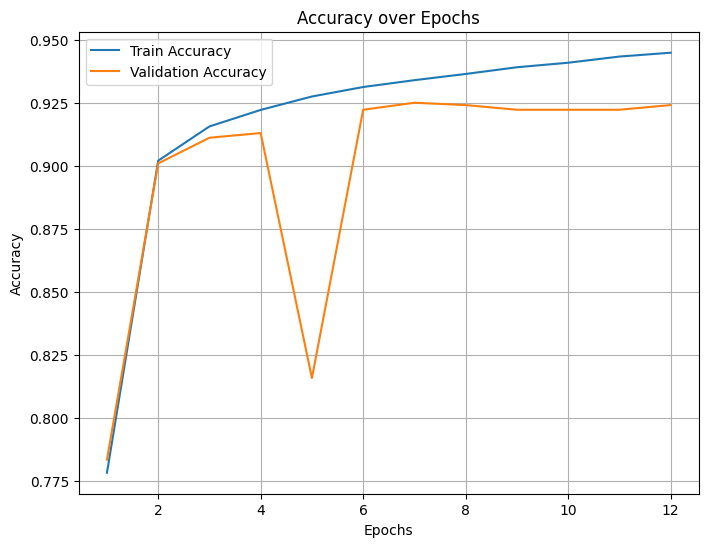

[I 2023-08-14 17:06:24,167] Trial 1 finished with value: 0.925 and parameters: {'lr': 9.913342973613262e-06, 'batch': 108, 'maxlen': 35}. Best is trial 0 with value: 0.927450980392157.


Best Train Accuracy: 0.9339537613448198, Best Validation Accuracy: 0.925


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 211008.14it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 239921.09it/s]


Padding sequences...


Generating attention masks: 100%|██████████| 973/973 [00:00<00:00, 85871.81it/s]


start training


training epoch 0: 100%|█████████████████████| 2168/2168 [02:18<00:00, 15.63it/s]


start predict


2168it [00:49, 43.38it/s]


start predict


12it [00:00, 48.05it/s]


Epoch 0,  Average training loss: 0.1479 , Train accuracy : 0.9099, Validation accuracy : 0.8924


training epoch 1: 100%|█████████████████████| 2168/2168 [02:18<00:00, 15.64it/s]


start predict


2168it [00:50, 43.33it/s]


start predict


12it [00:00, 47.83it/s]


Epoch 1,  Average training loss: 0.0675 , Train accuracy : 0.9291, Validation accuracy : 0.9195


training epoch 2: 100%|█████████████████████| 2168/2168 [02:18<00:00, 15.63it/s]


start predict


2168it [00:50, 43.23it/s]


start predict


12it [00:00, 47.96it/s]


Epoch 2,  Average training loss: 0.0560 , Train accuracy : 0.9388, Validation accuracy : 0.9095


training epoch 3: 100%|█████████████████████| 2168/2168 [02:18<00:00, 15.62it/s]


start predict


2168it [00:50, 43.20it/s]


start predict


12it [00:00, 47.72it/s]


Epoch 3,  Average training loss: 0.0505 , Train accuracy : 0.9451, Validation accuracy : 0.9290


training epoch 4: 100%|█████████████████████| 2168/2168 [02:18<00:00, 15.62it/s]


start predict


2168it [00:50, 43.22it/s]


start predict


12it [00:00, 48.08it/s]


Epoch 4,  Average training loss: 0.0466 , Train accuracy : 0.9502, Validation accuracy : 0.9028


training epoch 5: 100%|█████████████████████| 2168/2168 [02:18<00:00, 15.61it/s]


start predict


2168it [00:50, 43.20it/s]


start predict


12it [00:00, 48.13it/s]


Epoch 5,  Average training loss: 0.0430 , Train accuracy : 0.9532, Validation accuracy : 0.9085


training epoch 6: 100%|█████████████████████| 2168/2168 [02:18<00:00, 15.61it/s]


start predict


2168it [00:50, 43.16it/s]


start predict


12it [00:00, 47.84it/s]


Epoch 6,  Average training loss: 0.0406 , Train accuracy : 0.9586, Validation accuracy : 0.9095


training epoch 7: 100%|█████████████████████| 2168/2168 [02:18<00:00, 15.60it/s]


start predict


2168it [00:50, 43.14it/s]


start predict


12it [00:00, 47.77it/s]


Epoch 7,  Average training loss: 0.0383 , Train accuracy : 0.9618, Validation accuracy : 0.9233


training epoch 8: 100%|█████████████████████| 2168/2168 [02:19<00:00, 15.60it/s]


start predict


2168it [00:50, 43.13it/s]


start predict


12it [00:00, 47.97it/s]


Epoch 8,  Average training loss: 0.0358 , Train accuracy : 0.9638, Validation accuracy : 0.9280
[Early Stopping]5 epoch에서 중단.[Early Stopping]


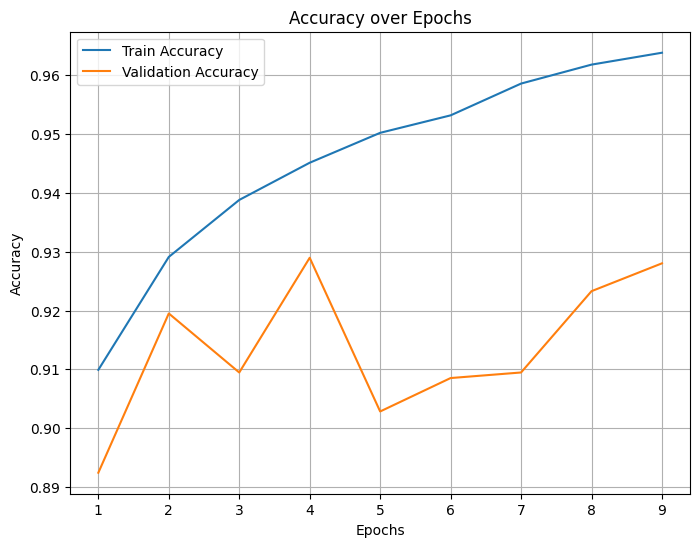

[I 2023-08-14 17:35:00,971] Trial 2 finished with value: 0.9289772727272726 and parameters: {'lr': 2.6236906504489848e-05, 'batch': 88, 'maxlen': 64}. Best is trial 2 with value: 0.9289772727272726.


Best Train Accuracy: 0.9451369087554511, Best Validation Accuracy: 0.9289772727272726


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 215058.11it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 260205.16it/s]


Padding sequences...


Generating attention masks: 100%|██████████| 973/973 [00:00<00:00, 51535.67it/s]


start training


training epoch 0: 100%|█████████████████████| 2193/2193 [03:53<00:00,  9.38it/s]


start predict


2193it [01:30, 24.35it/s]


start predict


12it [00:00, 26.60it/s]


Epoch 0,  Average training loss: 0.1751 , Train accuracy : 0.8945, Validation accuracy : 0.8867


training epoch 1: 100%|█████████████████████| 2193/2193 [03:54<00:00,  9.36it/s]


start predict


2193it [01:30, 24.34it/s]


start predict


12it [00:00, 26.78it/s]


Epoch 1,  Average training loss: 0.0852 , Train accuracy : 0.9168, Validation accuracy : 0.9067


training epoch 2: 100%|█████████████████████| 2193/2193 [03:54<00:00,  9.35it/s]


start predict


2193it [01:30, 24.34it/s]


start predict


12it [00:00, 26.66it/s]


Epoch 2,  Average training loss: 0.0676 , Train accuracy : 0.9269, Validation accuracy : 0.9134


training epoch 3: 100%|█████████████████████| 2193/2193 [03:54<00:00,  9.35it/s]


start predict


2193it [01:30, 24.33it/s]


start predict


12it [00:00, 26.65it/s]


Epoch 3,  Average training loss: 0.0601 , Train accuracy : 0.9332, Validation accuracy : 0.9197


training epoch 4: 100%|█████████████████████| 2193/2193 [03:54<00:00,  9.35it/s]


start predict


2193it [01:30, 24.34it/s]


start predict


12it [00:00, 26.69it/s]


Epoch 4,  Average training loss: 0.0557 , Train accuracy : 0.9366, Validation accuracy : 0.9243


training epoch 5: 100%|█████████████████████| 2193/2193 [03:54<00:00,  9.35it/s]


start predict


2193it [01:30, 24.33it/s]


start predict


12it [00:00, 26.81it/s]


Epoch 5,  Average training loss: 0.0523 , Train accuracy : 0.9418, Validation accuracy : 0.9135


training epoch 6: 100%|█████████████████████| 2193/2193 [03:54<00:00,  9.35it/s]


start predict


2193it [01:30, 24.33it/s]


start predict


12it [00:00, 26.75it/s]


Epoch 6,  Average training loss: 0.0496 , Train accuracy : 0.9446, Validation accuracy : 0.9201


training epoch 7: 100%|█████████████████████| 2193/2193 [03:54<00:00,  9.35it/s]


start predict


2193it [01:30, 24.33it/s]


start predict


12it [00:00, 26.74it/s]


Epoch 7,  Average training loss: 0.0473 , Train accuracy : 0.9482, Validation accuracy : 0.9258


training epoch 8: 100%|█████████████████████| 2193/2193 [03:54<00:00,  9.35it/s]


start predict


2193it [01:30, 24.32it/s]


start predict


12it [00:00, 26.80it/s]


Epoch 8,  Average training loss: 0.0455 , Train accuracy : 0.9507, Validation accuracy : 0.9197


training epoch 9: 100%|█████████████████████| 2193/2193 [03:54<00:00,  9.35it/s]


start predict


2193it [01:30, 24.33it/s]


start predict


12it [00:00, 26.74it/s]


Epoch 9,  Average training loss: 0.0436 , Train accuracy : 0.9524, Validation accuracy : 0.9282


training epoch 10: 100%|████████████████████| 2193/2193 [03:54<00:00,  9.36it/s]


start predict


2193it [01:30, 24.36it/s]


start predict


12it [00:00, 26.66it/s]


Epoch 10,  Average training loss: 0.0422 , Train accuracy : 0.9543, Validation accuracy : 0.9297


training epoch 11: 100%|████████████████████| 2193/2193 [03:54<00:00,  9.36it/s]


start predict


2193it [01:29, 24.38it/s]


start predict


12it [00:00, 26.76it/s]


Epoch 11,  Average training loss: 0.0405 , Train accuracy : 0.9567, Validation accuracy : 0.9330


training epoch 12: 100%|████████████████████| 2193/2193 [03:54<00:00,  9.37it/s]


start predict


2193it [01:29, 24.39it/s]


start predict


12it [00:00, 26.81it/s]


Epoch 12,  Average training loss: 0.0392 , Train accuracy : 0.9593, Validation accuracy : 0.9277


training epoch 13: 100%|████████████████████| 2193/2193 [03:54<00:00,  9.37it/s]


start predict


2193it [01:29, 24.39it/s]


start predict


12it [00:00, 26.74it/s]


Epoch 13,  Average training loss: 0.0378 , Train accuracy : 0.9610, Validation accuracy : 0.9192


training epoch 14: 100%|████████████████████| 2193/2193 [03:54<00:00,  9.37it/s]


start predict


2193it [01:29, 24.37it/s]


start predict


12it [00:00, 26.63it/s]


Epoch 14,  Average training loss: 0.0364 , Train accuracy : 0.9633, Validation accuracy : 0.9339


training epoch 15: 100%|████████████████████| 2193/2193 [03:54<00:00,  9.37it/s]


start predict


2193it [01:30, 24.36it/s]


start predict


12it [00:00, 26.67it/s]


Epoch 15,  Average training loss: 0.0354 , Train accuracy : 0.9647, Validation accuracy : 0.9349


training epoch 16: 100%|████████████████████| 2193/2193 [03:54<00:00,  9.36it/s]


start predict


2193it [01:30, 24.34it/s]


start predict


12it [00:00, 26.70it/s]


Epoch 16,  Average training loss: 0.0342 , Train accuracy : 0.9663, Validation accuracy : 0.9283


training epoch 17: 100%|████████████████████| 2193/2193 [03:54<00:00,  9.35it/s]


start predict


2193it [01:30, 24.34it/s]


start predict


12it [00:00, 26.67it/s]


Epoch 17,  Average training loss: 0.0332 , Train accuracy : 0.9684, Validation accuracy : 0.9277


training epoch 18: 100%|████████████████████| 2193/2193 [03:54<00:00,  9.35it/s]


start predict


2193it [01:30, 24.33it/s]


start predict


12it [00:00, 26.56it/s]


Epoch 18,  Average training loss: 0.0322 , Train accuracy : 0.9698, Validation accuracy : 0.9306


training epoch 19: 100%|████████████████████| 2193/2193 [03:54<00:00,  9.35it/s]


start predict


2193it [01:30, 24.33it/s]


start predict


12it [00:00, 26.75it/s]


Epoch 19,  Average training loss: 0.0313 , Train accuracy : 0.9713, Validation accuracy : 0.9325


training epoch 20: 100%|████████████████████| 2193/2193 [03:54<00:00,  9.35it/s]


start predict


2193it [01:30, 24.34it/s]


start predict


12it [00:00, 26.64it/s]

Epoch 20,  Average training loss: 0.0304 , Train accuracy : 0.9726, Validation accuracy : 0.9297
[Early Stopping]5 epoch에서 중단.[Early Stopping]


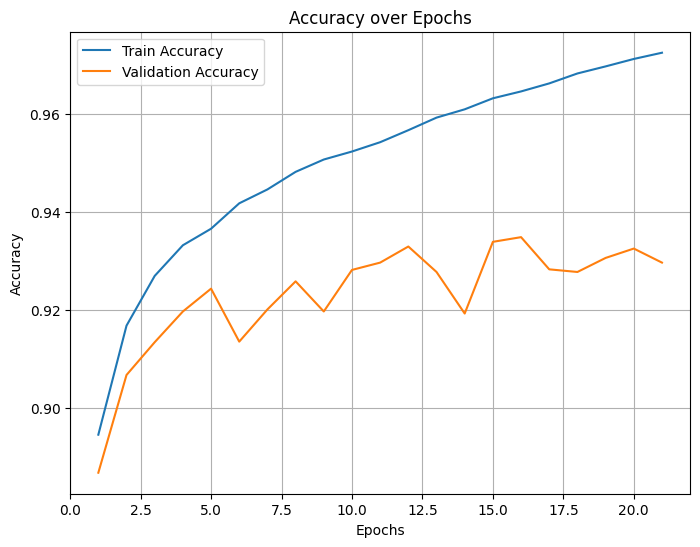

[I 2023-08-14 19:29:00,232] Trial 3 finished with value: 0.9348659003831417 and parameters: {'lr': 1.341242265866327e-05, 'batch': 87, 'maxlen': 110}. Best is trial 3 with value: 0.9348659003831417.


Best Train Accuracy: 0.9646786273985671, Best Validation Accuracy: 0.9348659003831417


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 213320.88it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 261522.45it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 973/973 [00:00<00:00, 156987.91it/s]


start training


training epoch 0: 100%|█████████████████████| 1590/1590 [01:16<00:00, 20.65it/s]


start predict


1590it [00:27, 58.32it/s]


start predict


9it [00:00, 65.38it/s]


Epoch 0,  Average training loss: 0.1956 , Train accuracy : 0.8798, Validation accuracy : 0.8725


training epoch 1: 100%|█████████████████████| 1590/1590 [01:17<00:00, 20.62it/s]


start predict


1590it [00:27, 58.21it/s]


start predict


9it [00:00, 65.22it/s]


Epoch 1,  Average training loss: 0.0989 , Train accuracy : 0.9101, Validation accuracy : 0.9035


training epoch 2: 100%|█████████████████████| 1590/1590 [01:17<00:00, 20.59it/s]


start predict


1590it [00:27, 58.19it/s]


start predict


9it [00:00, 65.44it/s]


Epoch 2,  Average training loss: 0.0751 , Train accuracy : 0.9201, Validation accuracy : 0.9100


training epoch 3: 100%|█████████████████████| 1590/1590 [01:17<00:00, 20.60it/s]


start predict


1590it [00:27, 58.13it/s]


start predict


9it [00:00, 65.81it/s]


Epoch 3,  Average training loss: 0.0660 , Train accuracy : 0.9272, Validation accuracy : 0.9118


training epoch 4: 100%|█████████████████████| 1590/1590 [01:17<00:00, 20.61it/s]


start predict


1590it [00:27, 58.17it/s]


start predict


9it [00:00, 65.32it/s]


Epoch 4,  Average training loss: 0.0609 , Train accuracy : 0.9314, Validation accuracy : 0.9213


training epoch 5: 100%|█████████████████████| 1590/1590 [01:17<00:00, 20.60it/s]


start predict


1590it [00:27, 58.14it/s]


start predict


9it [00:00, 65.31it/s]


Epoch 5,  Average training loss: 0.0574 , Train accuracy : 0.9344, Validation accuracy : 0.9116


training epoch 6: 100%|█████████████████████| 1590/1590 [01:17<00:00, 20.60it/s]


start predict


1590it [00:27, 58.14it/s]


start predict


9it [00:00, 65.44it/s]


Epoch 6,  Average training loss: 0.0542 , Train accuracy : 0.9378, Validation accuracy : 0.9098


training epoch 7: 100%|█████████████████████| 1590/1590 [01:17<00:00, 20.61it/s]


start predict


1590it [00:27, 58.15it/s]


start predict


9it [00:00, 64.97it/s]


Epoch 7,  Average training loss: 0.0523 , Train accuracy : 0.9403, Validation accuracy : 0.9296


training epoch 8: 100%|█████████████████████| 1590/1590 [01:17<00:00, 20.59it/s]


start predict


1590it [00:27, 58.11it/s]


start predict


9it [00:00, 64.08it/s]


Epoch 8,  Average training loss: 0.0500 , Train accuracy : 0.9423, Validation accuracy : 0.9125


training epoch 9: 100%|█████████████████████| 1590/1590 [01:17<00:00, 20.60it/s]


start predict


1590it [00:27, 58.12it/s]


start predict


9it [00:00, 65.81it/s]


Epoch 9,  Average training loss: 0.0483 , Train accuracy : 0.9452, Validation accuracy : 0.9287


training epoch 10: 100%|████████████████████| 1590/1590 [01:17<00:00, 20.61it/s]


start predict


1590it [00:27, 58.15it/s]


start predict


9it [00:00, 65.58it/s]


Epoch 10,  Average training loss: 0.0469 , Train accuracy : 0.9473, Validation accuracy : 0.9162


training epoch 11: 100%|████████████████████| 1590/1590 [01:17<00:00, 20.59it/s]


start predict


1590it [00:27, 58.16it/s]


start predict


9it [00:00, 65.09it/s]


Epoch 11,  Average training loss: 0.0456 , Train accuracy : 0.9485, Validation accuracy : 0.9287


training epoch 12: 100%|████████████████████| 1590/1590 [01:17<00:00, 20.61it/s]


start predict


1590it [00:27, 58.09it/s]


start predict


9it [00:00, 65.23it/s]


Epoch 12,  Average training loss: 0.0443 , Train accuracy : 0.9515, Validation accuracy : 0.9248
[Early Stopping]5 epoch에서 중단.[Early Stopping]


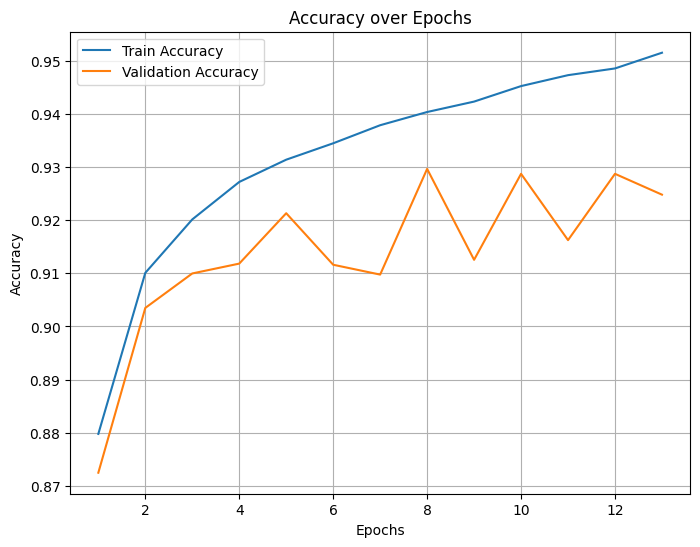

[I 2023-08-14 19:51:52,590] Trial 4 finished with value: 0.9296296296296297 and parameters: {'lr': 1.1812022667541407e-05, 'batch': 120, 'maxlen': 33}. Best is trial 3 with value: 0.9348659003831417.


Best Train Accuracy: 0.9403249475890986, Best Validation Accuracy: 0.9296296296296297


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 213284.48it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 260039.36it/s]


Padding sequences...


Generating attention masks: 100%|██████████| 973/973 [00:00<00:00, 83631.66it/s]


start training


training epoch 0: 100%|█████████████████████| 1645/1645 [02:20<00:00, 11.67it/s]


start predict


1645it [00:52, 31.24it/s]


start predict


9it [00:00, 34.54it/s]


Epoch 0,  Average training loss: 0.1655 , Train accuracy : 0.8998, Validation accuracy : 0.8850


training epoch 1: 100%|█████████████████████| 1645/1645 [02:21<00:00, 11.65it/s]


start predict


1645it [00:52, 31.27it/s]


start predict


9it [00:00, 34.82it/s]


Epoch 1,  Average training loss: 0.0790 , Train accuracy : 0.9208, Validation accuracy : 0.9099


training epoch 2: 100%|█████████████████████| 1645/1645 [02:21<00:00, 11.65it/s]


start predict


1645it [00:52, 31.26it/s]


start predict


9it [00:00, 35.14it/s]


Epoch 2,  Average training loss: 0.0642 , Train accuracy : 0.9296, Validation accuracy : 0.9219


training epoch 3: 100%|█████████████████████| 1645/1645 [02:21<00:00, 11.65it/s]


start predict


1645it [00:52, 31.25it/s]


start predict


9it [00:00, 34.63it/s]


Epoch 3,  Average training loss: 0.0576 , Train accuracy : 0.9357, Validation accuracy : 0.9217


training epoch 4: 100%|█████████████████████| 1645/1645 [02:21<00:00, 11.65it/s]


start predict


1645it [00:52, 31.25it/s]


start predict


9it [00:00, 34.56it/s]


Epoch 4,  Average training loss: 0.0533 , Train accuracy : 0.9403, Validation accuracy : 0.9160


training epoch 5: 100%|█████████████████████| 1645/1645 [02:21<00:00, 11.65it/s]


start predict


1645it [00:52, 31.27it/s]


start predict


9it [00:00, 34.48it/s]


Epoch 5,  Average training loss: 0.0504 , Train accuracy : 0.9434, Validation accuracy : 0.9227


training epoch 6: 100%|█████████████████████| 1645/1645 [02:21<00:00, 11.66it/s]


start predict


1645it [00:52, 31.30it/s]


start predict


9it [00:00, 34.68it/s]


Epoch 6,  Average training loss: 0.0472 , Train accuracy : 0.9475, Validation accuracy : 0.9192


training epoch 7: 100%|█████████████████████| 1645/1645 [02:21<00:00, 11.66it/s]


start predict


1645it [00:52, 31.27it/s]


start predict


9it [00:00, 34.68it/s]


Epoch 7,  Average training loss: 0.0450 , Train accuracy : 0.9499, Validation accuracy : 0.9215


training epoch 8: 100%|█████████████████████| 1645/1645 [02:21<00:00, 11.65it/s]


start predict


1645it [00:52, 31.22it/s]


start predict


9it [00:00, 34.63it/s]


Epoch 8,  Average training loss: 0.0432 , Train accuracy : 0.9526, Validation accuracy : 0.9227


training epoch 9: 100%|█████████████████████| 1645/1645 [02:21<00:00, 11.64it/s]


start predict


1645it [00:52, 31.17it/s]


start predict


9it [00:00, 34.73it/s]


Epoch 9,  Average training loss: 0.0413 , Train accuracy : 0.9554, Validation accuracy : 0.9236


training epoch 10: 100%|████████████████████| 1645/1645 [02:21<00:00, 11.63it/s]


start predict


1645it [00:52, 31.16it/s]


start predict


9it [00:00, 34.57it/s]


Epoch 10,  Average training loss: 0.0396 , Train accuracy : 0.9576, Validation accuracy : 0.9236


training epoch 11: 100%|████████████████████| 1645/1645 [02:21<00:00, 11.62it/s]


start predict


1645it [00:52, 31.13it/s]


start predict


9it [00:00, 34.44it/s]


Epoch 11,  Average training loss: 0.0382 , Train accuracy : 0.9602, Validation accuracy : 0.9232


training epoch 12: 100%|████████████████████| 1645/1645 [02:21<00:00, 11.61it/s]


start predict


1645it [00:52, 31.10it/s]


start predict


9it [00:00, 34.65it/s]


Epoch 12,  Average training loss: 0.0364 , Train accuracy : 0.9630, Validation accuracy : 0.9176


training epoch 13: 100%|████████████████████| 1645/1645 [02:21<00:00, 11.60it/s]


start predict


1645it [00:52, 31.08it/s]


start predict


9it [00:00, 34.55it/s]


Epoch 13,  Average training loss: 0.0354 , Train accuracy : 0.9648, Validation accuracy : 0.9221


training epoch 14: 100%|████████████████████| 1645/1645 [02:21<00:00, 11.60it/s]


start predict


1645it [00:52, 31.07it/s]


start predict


9it [00:00, 34.45it/s]


Epoch 14,  Average training loss: 0.0340 , Train accuracy : 0.9672, Validation accuracy : 0.9217
[Early Stopping]5 epoch에서 중단.[Early Stopping]


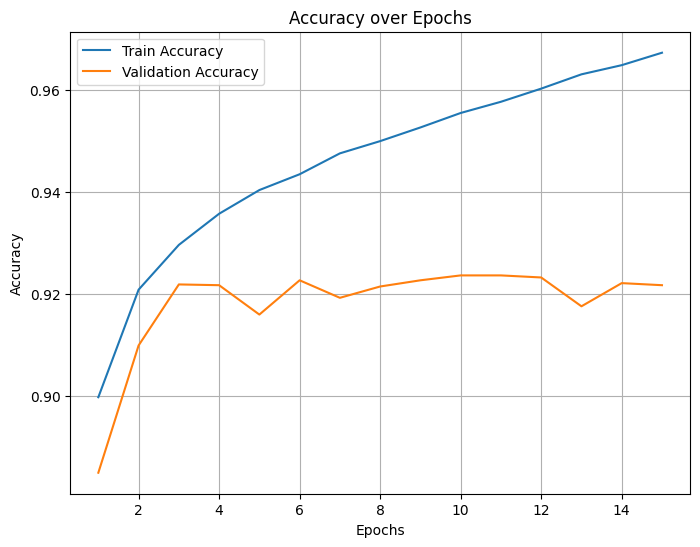

[I 2023-08-14 20:40:41,556] Trial 5 finished with value: 0.9236270753512132 and parameters: {'lr': 1.809441974697672e-05, 'batch': 116, 'maxlen': 66}. Best is trial 3 with value: 0.9348659003831417.


Best Train Accuracy: 0.9554111495417438, Best Validation Accuracy: 0.9236270753512132


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 212656.54it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 255817.58it/s]


Padding sequences...


Generating attention masks: 100%|██████████| 973/973 [00:00<00:00, 48430.08it/s]


start training


training epoch 0: 100%|█████████████████████| 1835/1835 [04:11<00:00,  7.30it/s]


start predict


1835it [01:36, 18.92it/s]


start predict


10it [00:00, 20.79it/s]


Epoch 0,  Average training loss: 0.2642 , Train accuracy : 0.5793, Validation accuracy : 0.5668


training epoch 1: 100%|█████████████████████| 1835/1835 [04:12<00:00,  7.28it/s]


start predict


1835it [01:37, 18.91it/s]


start predict


10it [00:00, 20.67it/s]


Epoch 1,  Average training loss: 0.2504 , Train accuracy : 0.5791, Validation accuracy : 0.5511


training epoch 2: 100%|█████████████████████| 1835/1835 [04:12<00:00,  7.28it/s]


start predict


1835it [01:37, 18.91it/s]


start predict


10it [00:00, 20.79it/s]


Epoch 2,  Average training loss: 0.2390 , Train accuracy : 0.6373, Validation accuracy : 0.6293


training epoch 3: 100%|█████████████████████| 1835/1835 [04:12<00:00,  7.28it/s]


start predict


1835it [01:37, 18.92it/s]


start predict


10it [00:00, 20.69it/s]


Epoch 3,  Average training loss: 0.2223 , Train accuracy : 0.7176, Validation accuracy : 0.7003


training epoch 4: 100%|█████████████████████| 1835/1835 [04:12<00:00,  7.28it/s]


start predict


1835it [01:37, 18.91it/s]


start predict


10it [00:00, 20.63it/s]


Epoch 4,  Average training loss: 0.2075 , Train accuracy : 0.7341, Validation accuracy : 0.7182


training epoch 5: 100%|█████████████████████| 1835/1835 [04:12<00:00,  7.28it/s]


start predict


1835it [01:36, 18.92it/s]


start predict


10it [00:00, 20.75it/s]


Epoch 5,  Average training loss: 0.1947 , Train accuracy : 0.7413, Validation accuracy : 0.7177


training epoch 6: 100%|█████████████████████| 1835/1835 [04:12<00:00,  7.28it/s]


start predict


1835it [01:37, 18.91it/s]


start predict


10it [00:00, 20.68it/s]


Epoch 6,  Average training loss: 0.1814 , Train accuracy : 0.8056, Validation accuracy : 0.7963


training epoch 7: 100%|█████████████████████| 1835/1835 [04:12<00:00,  7.27it/s]


start predict


1835it [01:37, 18.90it/s]


start predict


10it [00:00, 20.66it/s]


Epoch 7,  Average training loss: 0.1695 , Train accuracy : 0.8133, Validation accuracy : 0.8091


training epoch 8: 100%|█████████████████████| 1835/1835 [04:12<00:00,  7.27it/s]


start predict


1835it [01:37, 18.90it/s]


start predict


10it [00:00, 20.71it/s]


Epoch 8,  Average training loss: 0.1600 , Train accuracy : 0.8196, Validation accuracy : 0.8178


training epoch 9: 100%|█████████████████████| 1835/1835 [04:12<00:00,  7.28it/s]


start predict


1835it [01:37, 18.91it/s]


start predict


10it [00:00, 20.75it/s]


Epoch 9,  Average training loss: 0.1514 , Train accuracy : 0.8258, Validation accuracy : 0.8221


training epoch 10: 100%|████████████████████| 1835/1835 [04:12<00:00,  7.28it/s]


start predict


1835it [01:36, 18.93it/s]


start predict


10it [00:00, 20.67it/s]


Epoch 10,  Average training loss: 0.1432 , Train accuracy : 0.8344, Validation accuracy : 0.8236


training epoch 11: 100%|████████████████████| 1835/1835 [04:12<00:00,  7.28it/s]


start predict


1835it [01:36, 18.94it/s]


start predict


10it [00:00, 20.73it/s]


Epoch 11,  Average training loss: 0.1351 , Train accuracy : 0.8462, Validation accuracy : 0.8419


training epoch 12: 100%|████████████████████| 1835/1835 [04:12<00:00,  7.28it/s]


start predict


1835it [01:36, 18.95it/s]


start predict


10it [00:00, 20.77it/s]


Epoch 12,  Average training loss: 0.1269 , Train accuracy : 0.8599, Validation accuracy : 0.8488


training epoch 13: 100%|████████████████████| 1835/1835 [04:11<00:00,  7.28it/s]


start predict


1835it [01:36, 18.95it/s]


start predict


10it [00:00, 20.78it/s]


Epoch 13,  Average training loss: 0.1195 , Train accuracy : 0.8710, Validation accuracy : 0.8707


training epoch 14: 100%|████████████████████| 1835/1835 [04:11<00:00,  7.29it/s]


start predict


1835it [01:36, 18.96it/s]


start predict


10it [00:00, 20.80it/s]


Epoch 14,  Average training loss: 0.1134 , Train accuracy : 0.8779, Validation accuracy : 0.8727


training epoch 15: 100%|████████████████████| 1835/1835 [04:11<00:00,  7.29it/s]


start predict


1835it [01:36, 18.97it/s]


start predict


10it [00:00, 20.82it/s]


Epoch 15,  Average training loss: 0.1081 , Train accuracy : 0.8835, Validation accuracy : 0.8755


training epoch 16: 100%|████████████████████| 1835/1835 [04:11<00:00,  7.29it/s]


start predict


1835it [01:36, 18.96it/s]


start predict


10it [00:00, 20.79it/s]


Epoch 16,  Average training loss: 0.1035 , Train accuracy : 0.8870, Validation accuracy : 0.8748


training epoch 17: 100%|████████████████████| 1835/1835 [04:11<00:00,  7.29it/s]


start predict


1835it [01:36, 18.97it/s]


start predict


10it [00:00, 20.82it/s]


Epoch 17,  Average training loss: 0.0996 , Train accuracy : 0.8903, Validation accuracy : 0.8767


training epoch 18: 100%|████████████████████| 1835/1835 [04:11<00:00,  7.29it/s]


start predict


1835it [01:36, 18.96it/s]


start predict


10it [00:00, 20.80it/s]


Epoch 18,  Average training loss: 0.0961 , Train accuracy : 0.8924, Validation accuracy : 0.8769


training epoch 19: 100%|████████████████████| 1835/1835 [04:11<00:00,  7.28it/s]


start predict


1835it [01:36, 18.96it/s]


start predict


10it [00:00, 20.67it/s]


Epoch 19,  Average training loss: 0.0932 , Train accuracy : 0.8947, Validation accuracy : 0.8825


training epoch 20: 100%|████████████████████| 1835/1835 [04:11<00:00,  7.29it/s]


start predict


1835it [01:36, 18.96it/s]


start predict


10it [00:00, 20.77it/s]


Epoch 20,  Average training loss: 0.0908 , Train accuracy : 0.8969, Validation accuracy : 0.8790


training epoch 21: 100%|████████████████████| 1835/1835 [04:12<00:00,  7.28it/s]


start predict


1835it [01:36, 18.95it/s]


start predict


10it [00:00, 20.82it/s]


Epoch 21,  Average training loss: 0.0882 , Train accuracy : 0.8987, Validation accuracy : 0.8886


training epoch 22: 100%|████████████████████| 1835/1835 [04:12<00:00,  7.27it/s]


start predict


1835it [01:36, 18.93it/s]


start predict


10it [00:00, 20.79it/s]


Epoch 22,  Average training loss: 0.0861 , Train accuracy : 0.9005, Validation accuracy : 0.8919


training epoch 23: 100%|████████████████████| 1835/1835 [04:12<00:00,  7.28it/s]


start predict


1835it [01:36, 18.95it/s]


start predict


10it [00:00, 20.78it/s]


Epoch 23,  Average training loss: 0.0841 , Train accuracy : 0.9020, Validation accuracy : 0.8929


training epoch 24: 100%|████████████████████| 1835/1835 [04:11<00:00,  7.28it/s]


start predict


1835it [01:36, 18.96it/s]


start predict


10it [00:00, 20.75it/s]


Epoch 24,  Average training loss: 0.0822 , Train accuracy : 0.9034, Validation accuracy : 0.8857


training epoch 25: 100%|████████████████████| 1835/1835 [04:11<00:00,  7.28it/s]


start predict


1835it [01:36, 18.96it/s]


start predict


10it [00:00, 20.79it/s]


Epoch 25,  Average training loss: 0.0810 , Train accuracy : 0.9052, Validation accuracy : 0.8927


training epoch 26:  48%|██████████           | 875/1835 [02:00<02:10,  7.34it/s]

In [ ]:
# 최적화 수행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# 최적의 하이퍼파라미터 출력
print(study.best_params)

In [ ]:
# 최적의 하이퍼파라미터로 args 업데이트
for key, value in study.best_params.items():
    setattr(args, key, value)

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 128,
  "maxlen" : 64,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)